In [43]:
the_time = "20240530_213724"
image_file = "https://www.denverpost.com/wp-content/uploads/2016/04/20130508__20130509_Z00_FE09STGATSBYp3.jpg"

In [62]:
import json

with open(f"attention_results/{the_time}_attention_weights.json", "r") as file:
    attention_description = json.load(file)

    # Remove the 'attention_description' key if it exists
    if 'attention_description' in attention_description:
        del attention_description['attention_description']

    # Display the content of the JSON file nicely
    import pprint

    # pp = pprint.PrettyPrinter(indent=4)
    # pp.pprint(attention_description)


In [60]:
# Print the length of all tokens
all_tokens = attention_description.get("all_tokens", [])
print(f"Length of all tokens: {len(all_tokens)}")


Length of all tokens: 773


In [46]:
import torch

# Load the attention results from the specified file
attention_results_path = f"attention_results/{the_time}_attentions.pt"
attentions = torch.load(attention_results_path, map_location=torch.device('cpu'))

In [47]:
import numpy as np

num_decoders = 32
num_heads = 32
attention_matrices = []

for decoder_no in range(num_decoders):
    decoder_attention_matrices = []
    for attention_head in range(num_heads):
        final_size = attentions[-1][decoder_no][0, attention_head, :].shape[1]
        attention_matrix = np.zeros((final_size, final_size))

        first_matrix = np.array(attentions[0][decoder_no][0, attention_head, :])
        first_matrix_height = first_matrix.shape[0]

        # Insert the first_matrix into the top left corner of attention_matrix
        attention_matrix[:first_matrix.shape[0], :first_matrix.shape[1]] = first_matrix

        for generated_token_index, attention in enumerate(attentions[1:], start=0):
            new_token_row = np.array(attention[decoder_no][0, attention_head, :])
            new_token_row = np.pad(new_token_row, ((0, 0), (0, final_size - new_token_row.shape[1])), 'constant')

            attention_matrix[first_matrix_height + generated_token_index] = new_token_row

        # is_lower_triangular = np.allclose(attention_matrix, np.tril(attention_matrix))
        # print(f"Is the attention matrix for decoder {decoder_no}, head {attention_head} a lower triangular matrix? {is_lower_triangular}")
        decoder_attention_matrices.append(attention_matrix)
    attention_matrices.append(decoder_attention_matrices)



In [48]:
output_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["output_tokens"]]
input_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["input_tokens"]]


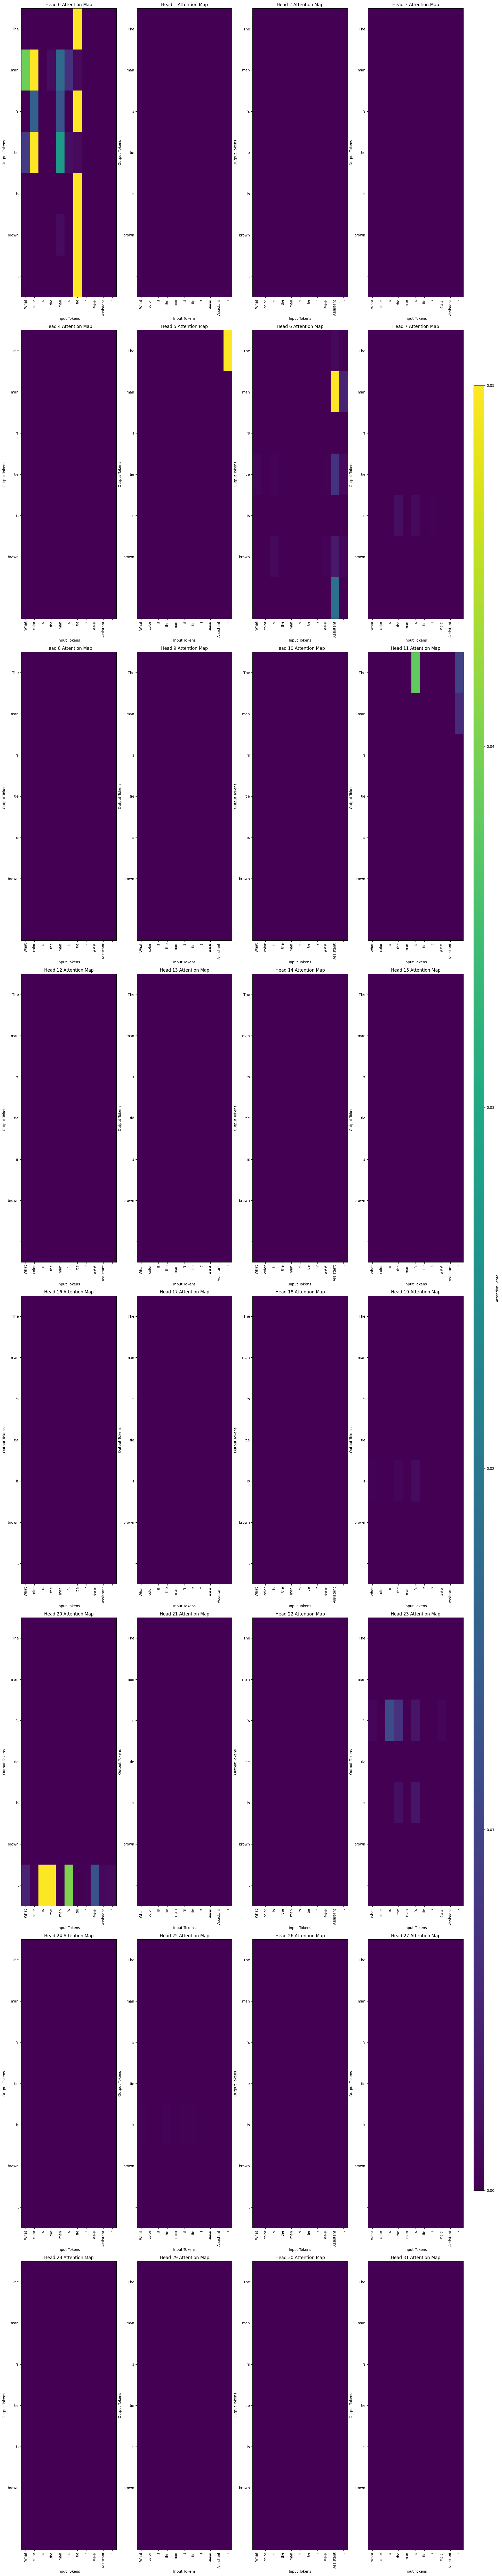

In [49]:
import matplotlib.pyplot as plt

image_token_indices = [i for i, token in enumerate(input_tokens) if token.startswith("image_")]
x_image_token_start = image_token_indices[0]
x_image_token_end = image_token_indices[-1] + 1

main_input_text = input_tokens[x_image_token_end + 1:len(input_tokens)]

# Define the decoder number to use
decoder_no = 31

# Create a figure with a grid of subplots for all attention heads
fig, axes = plt.subplots(8, 4, figsize=(20, 100))  # 8 rows and 4 columns

for attention_head in range(32):
    # Filter the attention matrix to just the top len(output_tokens) rows, and the first x_image_token_start columns
    filtered_attention_matrix = attention_matrices[decoder_no][attention_head][-len(output_tokens):, x_image_token_end + 1:len(input_tokens)]
    
    ax = axes[attention_head // 4, attention_head % 4]
    im = ax.imshow(filtered_attention_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=0.05)
    
    # Set the labels for the x and y axes using attention_description["all_tokens"]
    ax.set_xticks(np.arange(len(main_input_text)))
    ax.set_xticklabels(main_input_text, rotation=90)
    ax.set_yticks(np.arange(len(output_tokens)))
    ax.set_yticklabels(output_tokens)
    
    ax.set_ylabel('Output Tokens')
    ax.set_xlabel('Input Tokens')
    ax.set_title(f'Head {attention_head} Attention Map')

# Adjust layout and add a colorbar
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Attention Score')

plt.show()

In [50]:
# Print the whole output first
from textwrap import fill

wrapped_output = fill(attention_description["outputs"], width=80)
print(wrapped_output)
print("\n")
# Print a mapping of output_tokens and respective idx
for idx, token in enumerate(output_tokens):
    print(f"Index: {idx}, Token: {token}")



The man's tie is brown.


Index: 0, Token: The
Index: 1, Token: man
Index: 2, Token: 's
Index: 3, Token: tie
Index: 4, Token: is
Index: 5, Token: brown
Index: 6, Token: .


In [63]:
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
from ipywidgets import Button, HBox, VBox, Layout, Output, Label
from IPython.display import display

print(attention_description["outputs"])

def visualize_attention(idx, decoder_no):
    # Load the image from the URL
    print(output_tokens[idx])
    image_url = image_file
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # Scale the image to 384 x 384
    scaled_image = image.resize((384, 384))

    # Create 27 x 27 patches
    patch_size = 384 // 27

    # Create a figure with a grid of subplots for all attention heads
    fig, axes = plt.subplots(8, 4, figsize=(20, 20))  # 8 rows and 4 columns

    for attention_head in range(32):
        output_row = attention_matrices[decoder_no][attention_head][len(input_tokens) + idx, :]

        # Get the columns in the matrix (xlim_start, xlim_end) for the 7th row
        image_patches = output_row[x_image_token_start:x_image_token_end]
        # Ensure selected_columns is reshaped to 27x27
        image_patches_reshaped = np.reshape(image_patches, (27, 27))

        # Create a new image to draw patches on
        patched_image = scaled_image.copy()
        draw = ImageDraw.Draw(patched_image, "RGBA")

        for i in range(27):
            for j in range(27):
                x0 = j * patch_size
                y0 = i * patch_size
                x1 = x0 + patch_size
                y1 = y0 + patch_size
                # Normalize the opacity to be between 0 and 1
                opacity = image_patches_reshaped[i, j] / 0.005
                draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 255, int(255 * opacity)))

        # Display the patched image in the corresponding subplot
        ax = axes[attention_head // 4, attention_head % 4]
        ax.imshow(patched_image)
        ax.axis('off')
        ax.set_title(f'Head {attention_head}')

    # Adjust layout
    fig.tight_layout()
    plt.show()

    # Plot the average attention values across all heads
    avg_attention = np.mean([attention_matrices[decoder_no][head][len(input_tokens) + idx, x_image_token_start:x_image_token_end] for head in range(32)], axis=0)
    avg_attention_reshaped = np.reshape(avg_attention, (27, 27))

    plt.figure(figsize=(10, 10))
    plt.imshow(avg_attention_reshaped, cmap='viridis', aspect='auto')
    plt.colorbar(label='Average Attention Score')
    plt.title('Average Attention Map Across All Heads')
    plt.show()

# Create buttons for each output token and decoder number
output = Output()
token_buttons = [Button(description=f"{idx}: {token}") for idx, token in enumerate(output_tokens)]
decoder_buttons = [Button(description=f"Decoder {i}") for i in range(len(attention_matrices))]
decoder_label = Label(value="Selected Decoder: 0")


# Initialize the current decoder number
selected_token_idx = 0
current_decoder_no = 0

def on_token_button_click(b):
    global selected_token_idx
    selected_token_idx = int(b.description.split(":")[0])
    with output:
        output.clear_output()
        visualize_attention(selected_token_idx, current_decoder_no)
        # print(f"Selected Token Index: {selected_token_idx}, Current Decoder No: {current_decoder_no}")
        display_text.value = f"Selected Token Index: {selected_token_idx}"

def on_decoder_button_click(b):
    global current_decoder_no
    current_decoder_no = int(b.description.split(" ")[1])
    decoder_label.value = f"Selected Decoder: {current_decoder_no}"
    with output:
        output.clear_output()
        # print(f"Selected Decoder: {current_decoder_no}")
        if selected_token_idx is not None:
            visualize_attention(selected_token_idx, current_decoder_no)
            # print(f"Selected Token Index: {selected_token_idx}, Current Decoder No: {current_decoder_no}")
            display_text.value = f"Selected Token Index: {selected_token_idx}"

for button in token_buttons:
    button.on_click(on_token_button_click)

for button in decoder_buttons:
    button.on_click(on_decoder_button_click)

# Display buttons side by side with spacing between them
token_button_box = HBox(token_buttons, layout=Layout(justify_content='space-between', flex_flow='row wrap', gap='10px'))
decoder_button_box = HBox(decoder_buttons, layout=Layout(justify_content='space-between', flex_flow='row wrap', gap='10px'))
display_text = Label(value=f"Selected Token Index: {selected_token_idx}")
display(VBox([decoder_button_box, decoder_label, token_button_box, display_text, output]))

The man's tie is brown.
